### Import modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Grid-search of hyperparameters for candidate models
### 1. Number of topics 
### 2. $\alpha$<br>
#### Note about $\alpha$ parameter
In the following hyperparameter tuning, *gensim.models.ldamodel.LdaModel* and *gensim.models.wrappers.LdaMallet* take the alpha parameter as scalar instead of an 1D array, where the scalar value can be interpreted based on this article here: [webiste](http://i.amcat.nl/lda/understanding_alpha.html#:~:text=The%20alpha%20parameter&text=This%20parameter%20determines%20both%20the,gives%20a%20more%20sparse%20distribution.)<br>
Also the default alpha is 50(scalar) in *gensim.models.wrappers.LdaMallet* function(It doesn't work the same as gensim.models.ldamodel.LdaModel). <br><br>
From the website:<br>
"*The dirichlet distribution has a single parameter, often referred to as the alpha parameter. This parameter determines both the distribution and concentration of the dirichlet.<br>
If the alpha is a scalar (i.e. a single value), it only determines the concentration of the dirichlet. A higher alpha then gives a more dense distribution whereas a **lower alpha gives a more sparse distribution**. In the example of a bag of dices, a dense distribution means that each die in the bag is likely to have a faily uniform PMF. Thus, it’s a bag of fair dices. **If the distribution is sparse, this means that many dices are  skewed towards certain sides**. Since the distribution is symmetrical, this skew towards certain sides is random.*"<br><br>

### Candidate models
1. Standard LDA using Bayesian Variational Inference
2. LDA using Gibbs Sampling (Mallet LDA)
3. Standard LDA with TF-IDF
4. Mallet LDA with TF-IDF
5. NMF
6. LSA

#### Model's Parameter details
- update_every: Number of documents to be iterated through for each update. Set to 0 for batch learning, > 1 for online iterative learning.
- chunksize: Number of documents to be used in each training chunk.
- passes: Number of passes through the corpus during training.
- alpha:
  Can be set to an 1D array of length equal to the number of expected topics that expresses our a-priori belief for 
  the each topics’ probability. Alternatively default prior selecting strategies can be employed by supplying a string:
       ’asymmetric’: Uses a fixed normalized asymmetric prior of 1.0 / topicno.
       ’auto’: Learns an asymmetric prior from the corpus (not available if distributed==True).
- per_word_topics True: the model also computes a list of topics, sorted in descending order of most likely topics 
  for each word, along with their phi values multiplied by the feature length (i.e. word count).
[documentation](https://radimrehurek.com/gensim/models/ldamodel.html)

<strong>Grid-Search code for Standard LDA using Bayesian Variational Inference</strong>
<code style="font-size: 10px; background-color:transparent;">
alpha_coherence = defaultdict(list)
for alpha in np.linspace(0.1, 2.0, 20):
    print(f"alpha = {alpha}")
    coherence_scores = []
    for num in range(5, 16):
        print(num, end = ' ')
        lda_model = gensim.models.ldamodel.LdaModel(corpus=term_doc,
                                                   id2word=dictionary,
                                                   num_topics=num, 
                                                   random_state=100,
                                                   update_every=1,
                                                   chunksize=2000,
                                                   passes=10,
                                                   alpha=alpha,
                                                   per_word_topics=True)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_uci')
        coherence_scores.append(coherence_model_lda.get_coherence())
    alpha_coherence[alpha] = coherence_scores
</code><br>
<strong>Grid-Search code for LDA using Gibbs Sampling (Mallet LDA)</strong>
<code style="font-size: 10px; background-color:transparent;">
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
alpha_coherence_m = defaultdict(list)
for alpha in np.linspace(0.1, 2.0, 20):
    print(f"alpha = {alpha}")
    coherence_scores = []
    for num in range(5, 16):
        print(num, end = ' ')
        ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,
                                                     corpus=term_doc, 
                                                     num_topics=num, 
                                                     alpha = alpha,
                                                     random_seed = 100,
                                                     id2word=dictionary)
        coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=dictionary, coherence='c_uci')
        coherence_scores.append(coherence_model_ldamallet.get_coherence())
    alpha_coherence_m[alpha] = coherence_scores
</code><br>
<strong>Grid-Search code for NMF</strong>
<code style="font-size: 10px; background-color:transparent;">
kappas = defaultdict(list)
for kappa in [0.005, 0.01, 0.05, 0.1, 0.25, 0.5]:
    print(f"Alpha={kappa} and num_topics is")
    for num_topics in range(3, 16):
        print(num_topics, end = '   ')
        nmf = Nmf(term_doc, num_topics=num_topics, kappa=kappa, eval_every=1000, id2word = dictionary, random_state = 100)
        coherence_model = CoherenceModel(model=nmf, texts=data_lemmatized, dictionary=dictionary, coherence='c_npmi')
        kappas[kappa].append(coherence_model.get_coherence())
        nmf = None
</code><br>
<strong>Line-Search code for LSA</strong>
<code style="font-size: 10px; background-color:transparent;">
coherence_scores_lsa = []
for num_topics in range(3, 31):
    print(num_topics, end = '   ')
    lsa_model = LsiModel(term_doc, num_topics=num_topics, id2word = dictionary)
    coherence_model = CoherenceModel(model=lsa_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_npmi')
    coherence_scores_lsa.append(coherence_model.get_coherence())
    lsa_model = None
</code>

### Load NLPpipeline and grid-search results

In [2]:
term_doc = pd.read_pickle('preprocessed_data/term_doc.pkl')
data_lemmatized = pd.read_pickle('preprocessed_data/data_lemmatized.pkl')
dictionary = pd.read_pickle('preprocessed_data/dictionary.pkl')
tf_idf = pd.read_pickle('preprocessed_data/tf_idf.pkl')

alpha_coherence = pd.read_pickle('./coherence_scores/alpha_coherence.pkl')
alpha_coherence_chunk100 = pd.read_pickle('coherence_scores/alpha_coherence_lda_std_chunk=100.pkl')
alpha_coherence_m = pd.read_pickle('coherence_scores/alpha_coherence_m.pkl')
alpha_coherence_tfidf = pd.read_pickle('coherence_scores/alpha_coherence_tfidf.pkl')
alpha_coherence_nmf = pd.read_pickle('coherence_scores/nmf_kappa_coherence.pkl')
coherence_lsa = pd.read_pickle('coherence_scores/lsa_coherence_scores.pkl')

### Plot the grid-search results

Standard LDA UCI scores with chunksize = 1


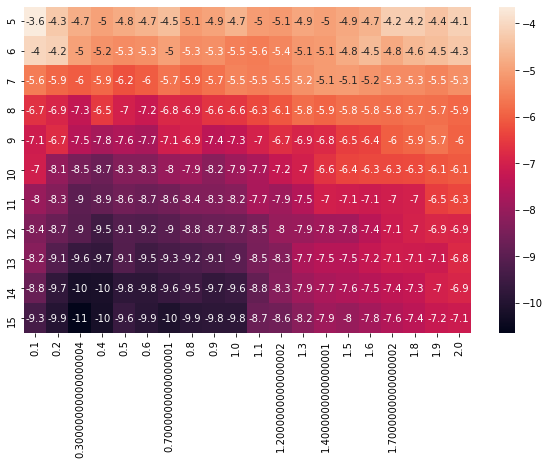

In [3]:
print(f"Standard LDA UCI scores with chunksize = 1")
plt.figure(figsize=(10,6))
sns.heatmap(alpha_coherence, annot=True);

Standard LDA UCI scores with chunksize = 100


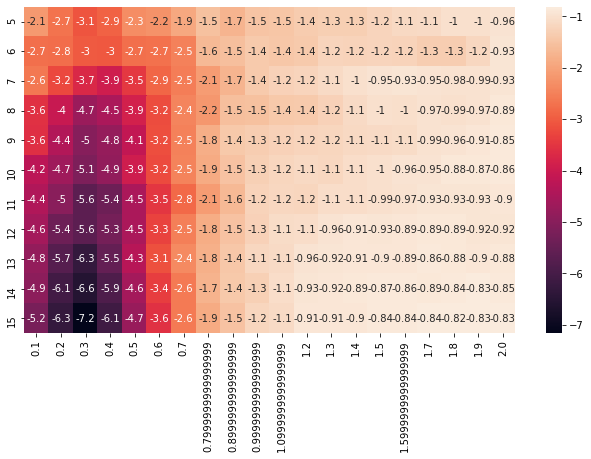

In [4]:
print(f"Standard LDA UCI scores with chunksize = 100")
plt.figure(figsize=(11,6))
sns.heatmap(alpha_coherence_chunk100, annot=True);

Mallet LDA UCI scores with chunksize = 1


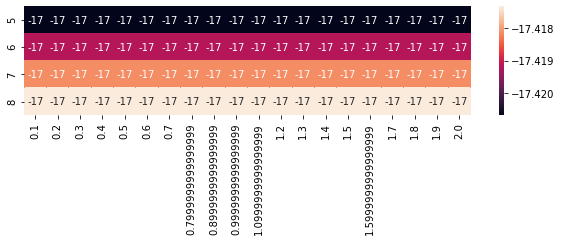

In [5]:
print(f"Mallet LDA UCI scores with chunksize = 1")
plt.figure(figsize=(10,2))
sns.heatmap(alpha_coherence_m, annot=True);

Standard LDA with TF-IDF UCI scores with chunksize = 1


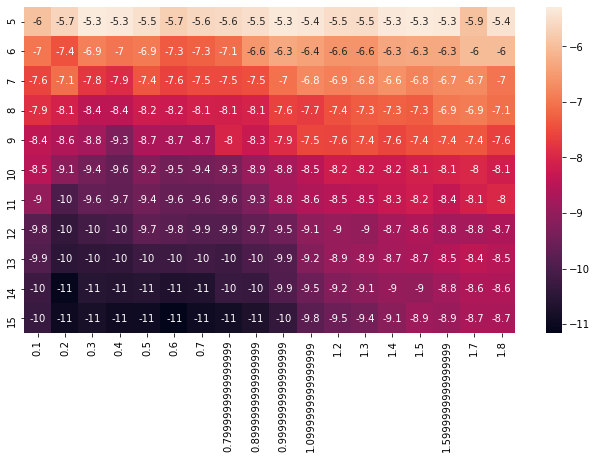

In [6]:
print(f"Standard LDA with TF-IDF UCI scores with chunksize = 1")
plt.figure(figsize=(11,6))
sns.heatmap(alpha_coherence_tfidf, annot=True);

NMF NPMI scores


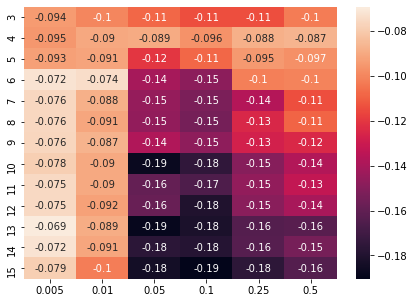

In [7]:
print(f"NMF NPMI scores")
plt.figure(figsize=(7,5))
sns.heatmap(alpha_coherence_nmf, annot=True);

LSA NPMI scores


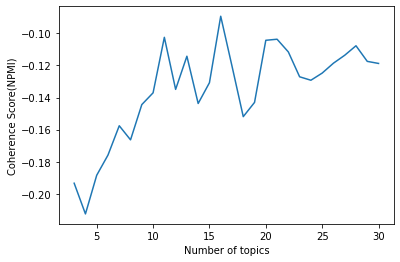

In [8]:
print(f"LSA NPMI scores")
plt.plot(range(3, 31), coherence_lsa)
plt.xlabel('Number of topics')
plt.ylabel('Coherence Score(NPMI)');

#### Quick peek at LDA model vs BERT model

In [9]:
BERT_preds, LDA_preds = pd.read_pickle('prediction/BERT_preds.pkl'), pd.read_pickle('prediction/LDA_preds.pkl')
BERT_proba, LDA_proba = pd.read_pickle('prediction/BERT_proba.pkl'), pd.read_pickle('prediction/LDA_proba.pkl')
mallet_lda_df = pd.read_pickle('lda_mallet_model/mallet_lda_df.pkl')

diff = pd.read_pickle('prediction/diff.pkl')
diff.insert(2, 'bert_perc', pd.Series(np.round(np.max(BERT_proba, axis = 1),2)))
diff.insert(4, 'lda_perc', pd.Series([np.round(np.max(prob),2) for prob in LDA_proba]))

In [10]:
topic_dict = {0.: "Platform/Device", 1.: "User Experience", 2.: "Value", 3.: "Service", 4.: "Trouble-shooting", 5.:"Shows"}

##### LDA Predicted label's distribution in training(?) set

In [11]:
pd.Series([topic_dict[topic_num] for topic_num in mallet_lda_df.Dominant_Topic.values]).value_counts() / len(mallet_lda_df)

Platform/Device     0.320945
Shows               0.158125
Trouble-shooting    0.144835
User Experience     0.129317
Value               0.128681
Service             0.118096
dtype: float64

##### BERT Predicted label's distribution in validation set
Predictions are evenly distributed.

In [12]:
pd.Series([topic_dict[topic_num] for topic_num in BERT_preds]).value_counts() / len(BERT_preds)

Shows               0.229190
Platform/Device     0.175394
User Experience     0.168868
Trouble-shooting    0.154703
Value               0.149133
Service             0.122712
dtype: float64

##### LDA Predicted label's distribution in validation set
1/3 of the predictions are Platform/Device

In [13]:
pd.Series([topic_dict[topic_num] for topic_num in LDA_preds]).value_counts() / len(LDA_preds)

Platform/Device     0.330097
Trouble-shooting    0.164412
Shows               0.145154
Value               0.127964
User Experience     0.120484
Service             0.111889
dtype: float64

##### BERT vs LDA 
The following are differently predicted topics with both models having more than 0.8 confidence(predicted probability)

In [14]:
diff_subset = diff.loc[(diff.bert_perc >= 0.60)&(diff.lda_perc >= 0.60), :]
pd.DataFrame.to_csv(diff_subset, 'diff_subset.csv')

##### Choosing topic by a user myself was quite hard as well since there are only 6 topics.
I think BERT model is more useful for the reviews. BERT models are more focused on the context rather than keywords. People express their love about movies and TV series in many different words, so LDA model got confused with the keywords, but BERT could catch that they are just talking about their favorite shows. It can also detect negative reviews and classify in the category of trouble-shooting rather than focusing on keywords.

In [15]:
diff_subset.style\
.set_properties(subset=['review'], **{'width': '700px'})

,review,bert_topic,bert_perc,lda_topic,lda_perc
0,"Goodbye to my cable bill, netflix is what you ... Goodbye to my cable bill, netflix is what you need. so much cheaper & i can use it on the go, whether im sitting at a restaurant waiting for my food or traveling!",Value,0.990000,Platform/Device,0.640000
1,"Needs work. This is a great app, but it has issues if you don't have good Internet. The video is ok but the sound is off. As I said before it needs work.",Platform/Device,0.750000,Trouble-shooting,0.640000
2,Very nice! At first I was a little bit skeptical about getting it because of the reviews that i had read. I decided to give it a try and trust me when I say that I dont regret doing it.,Service,0.940000,Platform/Device,0.770000
11,Five Stars Thanks its great,Value,1.000000,Platform/Device,0.760000
13,"only works when it feels like it. What is Netflix' problem?? It just won't work, it's a piece of junk right now, but usually it's pretty good.",Service,0.900000,Trouble-shooting,0.640000
14,Netflix is awesome! I love my Netflix app for Kindle Fire! I can watch my movies anytime and not tie up the TV! I recommend this to everyone!,Value,1.000000,Shows,0.770000
15,Love Netflix I love being able to watch my shows when I want. The movies and shows need to be updated more often though.,Shows,0.910000,Platform/Device,0.640000
22,Three Stars Netflix streaming only has old shows. Need more current shows. I'm dropping it and doing DVD only.,Shows,0.760000,Service,0.640000
52,"What would I do without this app Nexflix on the go, just like me. I have it on two different devices and can what wherever I am in a wifi area. Simply wonderful.",Trouble-shooting,0.610000,Platform/Device,0.720000
61,fjdkrkfjdjffidffifj Vjcjfifhdifudfidjfifjfjfjfifjfjfhfhdkdk Liu Judith uhh four djfifjfif,Shows,0.940000,Platform/Device,0.850000
